In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('Used bike price').getOrCreate()
spark

In [ ]:
#import data
df = spark.read.csv('/content/Used_Bikes.csv', header = True, inferSchema = True)
df.show()

+--------------------+------+---------+----------+------------+---+-----+-------------+
|           bike_name| price|     city|kms_driven|       owner|age|power|        brand|
+--------------------+------+---------+----------+------------+---+-----+-------------+
|TVS Star City Plu...| 35000|Ahmedabad|     17654| First Owner|  3|  110|          TVS|
|Royal Enfield Cla...|119900|    Delhi|     11000| First Owner|  4|  350|Royal Enfield|
|Triumph Daytona 675R|600000|    Delhi|       110| First Owner|  8|  675|      Triumph|
|TVS Apache RTR 180cc| 65000|Bangalore|     16329| First Owner|  4|  180|          TVS|
|Yamaha FZ S V 2.0...| 80000|Bangalore|     10000| First Owner|  3|  150|       Yamaha|
|    Yamaha FZs 150cc| 53499|    Delhi|     25000| First Owner|  6|  150|       Yamaha|
|Honda CB Hornet 1...| 85000|    Delhi|      8200| First Owner|  3|  160|        Honda|
|Hero Splendor Plu...| 45000|    Delhi|     12645| First Owner|  3|  100|         Hero|
|Royal Enfield Thu...|145000|Ban

In [ ]:
df.printSchema()

root
 |-- bike_name: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- kms_driven: integer (nullable = true)
 |-- owner: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- power: integer (nullable = true)
 |-- brand: string (nullable = true)



In [ ]:
#checking for null values
from pyspark.sql.functions import col
null_rows = df.filter((col("age").isNull()) | (col("age") == "") )
null_rows.show()

+--------------------+-----+-------+----------+------------+----+-----+-------------+
|           bike_name|price|   city|kms_driven|       owner| age|power|        brand|
+--------------------+-----+-------+----------+------------+----+-----+-------------+
|Royal Enfield Cla...|85000|  Delhi|     18000| First Owner|NULL|  350|Royal Enfield|
|  Bajaj Pulsar 150cc|23300|Nellore|     32000|Second Owner|NULL|  150|        Bajaj|
+--------------------+-----+-------+----------+------------+----+-----+-------------+



In [ ]:
from pyspark.sql.functions import col
null_rows = df.filter((col("price").isNull()) | (col("price") == "") )
null_rows.show()

+--------------------+-----+------+----------+-----------+---+-----+------+
|           bike_name|price|  city|kms_driven|      owner|age|power| brand|
+--------------------+-----+------+----------+-----------+---+-----+------+
| Bajaj Discover 100M| NULL| Delhi|     20000|First Owner|  8|  100| Bajaj|
|Honda CB Shine 125cc| NULL|Mumbai|      3000|First Owner|  4|  125| Honda|
|Yamaha Fazer 25 2...| NULL|Kadapa|     14500|First Owner|  4|  250|Yamaha|
+--------------------+-----+------+----------+-----------+---+-----+------+



In [ ]:
from pyspark.sql.functions import col
null_rows = df.filter((col("age").isNull()) | (col("age") == "") )
null_rows.show()

+--------------------+-----+-------+----------+------------+----+-----+-------------+
|           bike_name|price|   city|kms_driven|       owner| age|power|        brand|
+--------------------+-----+-------+----------+------------+----+-----+-------------+
|Royal Enfield Cla...|85000|  Delhi|     18000| First Owner|NULL|  350|Royal Enfield|
|  Bajaj Pulsar 150cc|23300|Nellore|     32000|Second Owner|NULL|  150|        Bajaj|
+--------------------+-----+-------+----------+------------+----+-----+-------------+



In [ ]:
#drop null values
df = df.na.drop()

In [ ]:
#drop duplicate instances
print("Number of rows before dropping null values:", df.count())
df = df.dropDuplicates()
print("Number of rows after dropping null values:", df.count())

Number of rows before dropping null values: 32642
Number of rows after dropping null values: 7319


In [ ]:
from pyspark.sql.types import IntegerType
df = df.withColumn('price', col('price').cast(IntegerType()))


In [ ]:
#checking for outliers using z score
from pyspark.sql.functions import col, mean, stddev, when
from pyspark.sql.functions import abs as spark_abs
from pyspark.sql import functions as F
def identify_outliers_zscore(df, columns, threshold=4):
    outliers = []
    for col_name in columns:
        zscore_column = f"zscore_{col_name}"
        mean_val = df.agg(F.mean(col(col_name)).alias('mean')).collect()[0]['mean']
        stddev_val = df.agg(F.stddev(col(col_name)).alias('stddev')).collect()[0]['stddev']


        df = df.withColumn(zscore_column, ((col(col_name) - mean_val) / stddev_val).alias(zscore_column))
        df_outliers = df.filter(F.abs(col(zscore_column)) > threshold)
        outliers.append((col_name, df_outliers.count()))
        df = df.drop(zscore_column)
    return df, outliers
columns_to_check = ["kms_driven", "age", "power", "price"]
df, outliers = identify_outliers_zscore(df, columns_to_check)
print("Outliers:")
for col_name, count in outliers:
    print(f"{col_name}: {count} outliers")

Outliers:
kms_driven: 25 outliers
age: 30 outliers
power: 84 outliers
price: 97 outliers


In [ ]:
#handling outliers by log transform
log_transform_cols = ["kms_driven", "age", "power", "price"]
for col_name in log_transform_cols:
    df = df.withColumn(f"log_{col_name}", log(when(col(col_name) <= 0, 1).otherwise(col(col_name))))



In [ ]:
df = df.dropDuplicates()

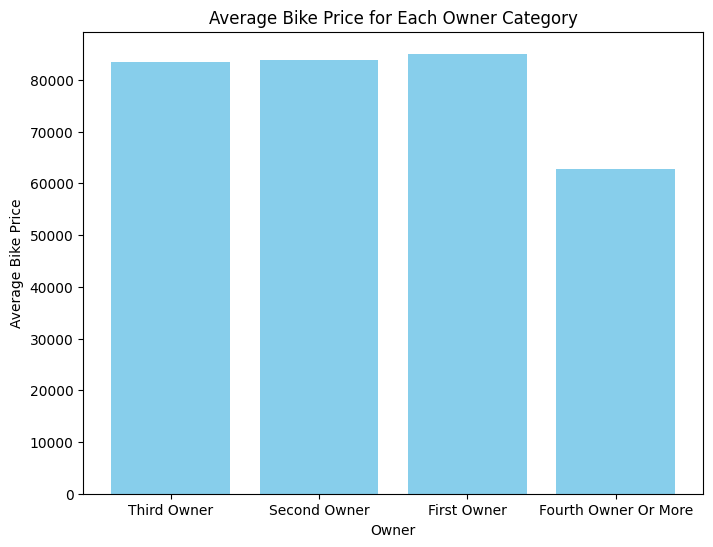

In [ ]:
#Average bike price for each owner category
from pyspark.sql.functions import mean
result = df.groupBy('owner').agg(mean('price').alias('average_price'))
result_pd = result.toPandas()
plt.figure(figsize=(8, 6))
plt.bar(result_pd['owner'], result_pd['average_price'], color='skyblue')
plt.xlabel('Owner')
plt.ylabel('Average Bike Price')
plt.title('Average Bike Price for Each Owner Category')
plt.show()

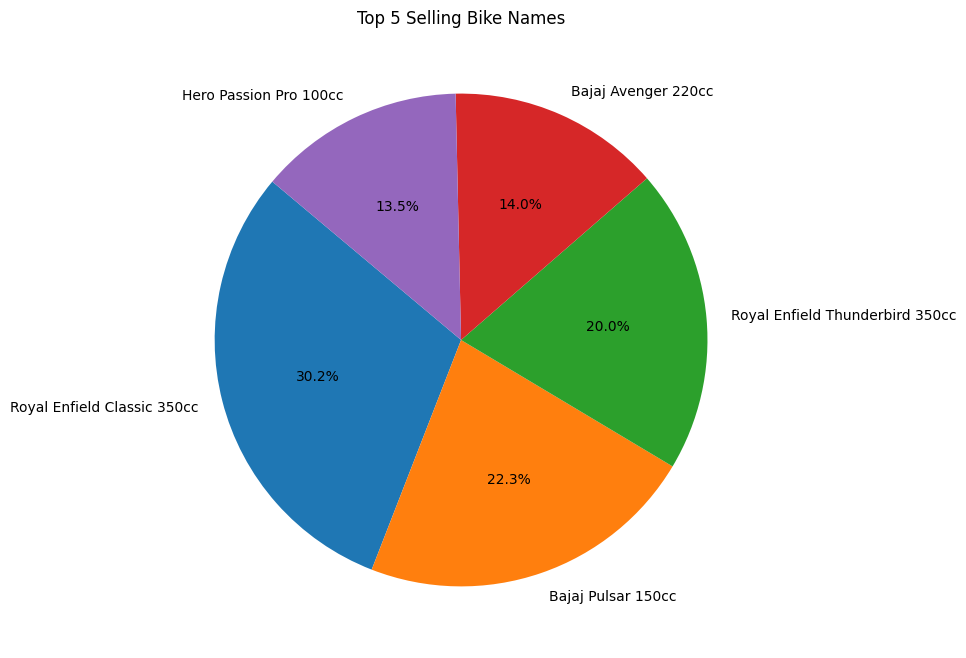

In [ ]:
#Top 5 selling bike name
from pyspark.sql.functions import count
result = df.groupBy('bike_name').agg(count('*').alias('count')).orderBy('count', ascending=False)
result_pd = result.limit(5).toPandas()
plt.figure(figsize=(8, 8))
plt.pie(result_pd['count'], labels=result_pd['bike_name'], startangle=140, autopct='%1.1f%%')
plt.title('Top 5 Selling Bike Names')
plt.show()






In [ ]:
#feature engineering by string indexer,featurehasher, vectorassembler
string_columns = ["bike_name", "city", "owner", "brand"]
indexers = [StringIndexer(inputCol=column, outputCol=f"{column}_index").fit(df) for column in string_columns]

In [ ]:

from pyspark.ml.feature import FeatureHasher
hasher = FeatureHasher(inputCols=[f"{column}_index" for column in string_columns], outputCol="hashed_features", numFeatures=100)
feature_columns = ["log_kms_driven", "log_age", "log_power", "bike_name_index", "city_index", "owner_index", "brand_index"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

In [ ]:
(training_data, testing_data) = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
#ML models
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor
linear_regression = LinearRegression(featuresCol="features", labelCol="log_price")
decision_tree = DecisionTreeRegressor(featuresCol="hashed_features", labelCol="log_price")
random_forest = RandomForestRegressor(featuresCol="hashed_features", labelCol="log_price")



In [ ]:
#Hyperparameter tuning
param_grid_lr = ParamGridBuilder().addGrid(linear_regression.regParam, [0.1, 0.01]).build()
param_grid_dt = ParamGridBuilder().addGrid(decision_tree.maxDepth, [5, 10]).build()
param_grid_rf = ParamGridBuilder().addGrid(random_forest.numTrees, [20, 50]).addGrid(random_forest.maxDepth, [5, 10]).build()



In [ ]:
evaluator = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="rmse")

In [ ]:
#Pipeline
pipeline_lr = Pipeline(stages=indexers + [assembler, linear_regression])
pipeline_dt = Pipeline(stages=indexers + [assembler,hasher, decision_tree])
pipeline_rf = Pipeline(stages=indexers + [assembler,hasher, random_forest])



In [ ]:
#cross validation
cv_lr = CrossValidator(estimator=pipeline_lr, estimatorParamMaps=param_grid_lr, evaluator=evaluator, numFolds=5)
cv_dt = CrossValidator(estimator=pipeline_dt, estimatorParamMaps=param_grid_dt, evaluator=evaluator, numFolds=5)
cv_rf = CrossValidator(estimator=pipeline_rf, estimatorParamMaps=param_grid_rf, evaluator=evaluator, numFolds=5)



In [ ]:
model_lr = cv_lr.fit(training_data)
model_dt = cv_dt.fit(training_data)
model_rf = cv_rf.fit(training_data)


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor, RandomForestRegressor,GeneralizedLinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.feature import VectorAssembler, StringIndexer,OneHotEncoder

In [ ]:
predictions_lr = model_lr.transform(testing_data)
predictions_dt = model_dt.transform(testing_data)
predictions_rf = model_rf.transform(testing_data)

In [ ]:
rmse_lr = evaluator.evaluate(predictions_lr)
rmse_dt = evaluator.evaluate(predictions_dt)
rmse_rf = evaluator.evaluate(predictions_rf)

In [ ]:
mae_lr = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="mae").evaluate(predictions_lr)
mae_dt = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="mae").evaluate(predictions_dt)
mae_rf = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="mae").evaluate(predictions_rf)

In [ ]:
r2_lr = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2").evaluate(predictions_lr)
r2_dt = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2").evaluate(predictions_dt)
r2_rf = RegressionEvaluator(labelCol="log_price", predictionCol="prediction", metricName="r2").evaluate(predictions_rf)

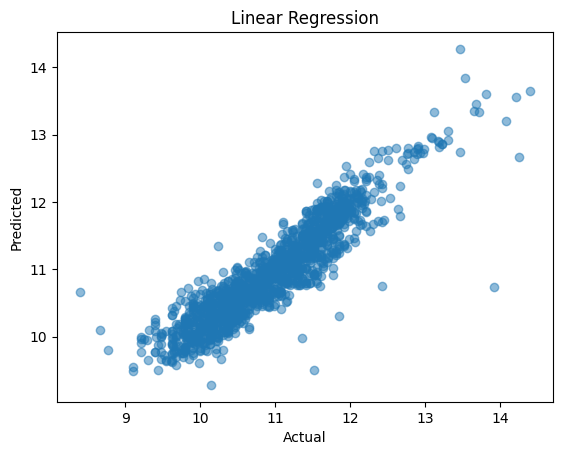

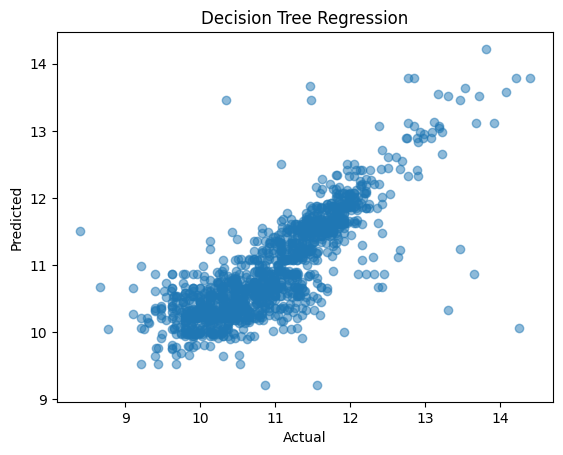

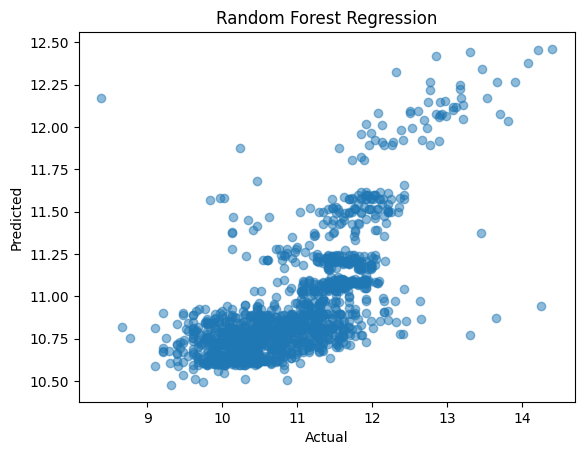

In [ ]:
#Plotting
import matplotlib.pyplot as plt
def scatter_plot(predictions, title):
    predictions_pd = predictions.select("log_price", "prediction").toPandas()
    plt.scatter(predictions_pd["log_price"], predictions_pd["prediction"], alpha=0.5)
    plt.title(title)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.show()

scatter_plot(predictions_lr, 'Linear Regression')
scatter_plot(predictions_dt, 'Decision Tree Regression')
scatter_plot(predictions_rf, 'Random Forest Regression')

In [ ]:
#Performance metrics
print("Linear Regression RMSE: {}".format(rmse_lr))
print("Decision Tree Regression RMSE: {}".format(rmse_dt))
print("Random Forest Regression RMSE: {}".format(rmse_rf))


print("Linear Regression MAE: {}".format(mae_lr))
print("Decision Tree Regression MAE: {}".format(mae_dt))
print("Random Forest Regression MAE: {}".format(mae_rf))


print("Linear Regression R2: {}".format(r2_lr))
print("Decision Tree Regression R2: {}".format(r2_dt))
print("Random Forest Regression R2: {}".format(r2_rf))


Linear Regression RMSE: 0.3285606345944293
Decision Tree Regression RMSE: 0.47761318339208386
Random Forest Regression RMSE: 0.6374574073150405
Linear Regression MAE: 0.23686497640055812
Decision Tree Regression MAE: 0.321967738150015
Random Forest Regression MAE: 0.513588066848885
Linear Regression R2: 0.8442240020667404
Decision Tree Regression R2: 0.6708285983671648
Random Forest Regression R2: 0.41362988370676035
